# 분류 및 연속모델 복합 구조 cVAE를 이용한 건식 개질 공정용 금속 촉매 생성 조성 최적화
### (EarlyStopping: Patience 40, Min_Delta 1e-9 반영)

In [1]:
import os, sys, torch, json
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 경로 설정
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from multilayer_model.m3_multi_bce import M3_Multi_BCE
from multilayer_model.m3_multi_mse import M3_Multi_MSE
from multilayer_loss.l_multi3_final_logic import l_multi3_final_loss
from vae_earlystopping import EarlyStopping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 800
print(f"Using device: {device}")

Using device: cuda


In [2]:
x1_raw = np.load('../data/metal.npy')
x2_raw = np.load('../data/support_norm.npy')
x3_raw = np.load('../data/pre_fin.npy')
c_raw = np.load('../data/re_fin.npy')

idx = np.arange(len(x1_raw))
tr_idx, te_idx = train_test_split(idx, test_size=0.1, random_state=42)
tr_idx, va_idx = train_test_split(tr_idx, test_size=0.1, random_state=42)

sc1, sc2, sc3, scc = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
def prep(d, i, s, f=False): return s.fit_transform(d[i]) if f else s.transform(d[i])

x1_tr, x1_va, x1_te = prep(x1_raw, tr_idx, sc1, True), prep(x1_raw, va_idx, sc1), prep(x1_raw, te_idx, sc1)
x2_tr, x2_va, x2_te = prep(x2_raw, tr_idx, sc2, True), prep(x2_raw, va_idx, sc2), prep(x2_raw, te_idx, sc2)
x3_tr, x3_va, x3_te = prep(x3_raw, tr_idx, sc3, True), prep(x3_raw, va_idx, sc3), prep(x3_raw, te_idx, sc3)
c_tr, c_va, c_te = prep(c_raw, tr_idx, scc, True), prep(c_raw, va_idx, scc), prep(c_raw, te_idx, scc)

def to_t(a): return torch.tensor(a, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(to_t(x1_tr), to_t(x2_tr), to_t(x3_tr), to_t(c_tr)), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(to_t(x1_va), to_t(x2_va), to_t(x3_va), to_t(c_va)), batch_size=64)
test_loader = DataLoader(TensorDataset(to_t(x1_te), to_t(x2_te), to_t(x3_te), to_t(c_te)), batch_size=64)

x_dims = [x1_tr.shape[1], x2_tr.shape[1], x3_tr.shape[1]]
c_dim = c_tr.shape[1]

In [3]:
def train_expert(model, mode='mse'):
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    # 사용자 요청 사양 반영: patience=40, min_delta=1e-9
    es = EarlyStopping(patience=40, min_delta=1e-9)
    
    print(f"\n--- Training {mode.upper()} Specialist Specialist ---")
    for epoch in range(1, EPOCHS + 1):
        model.train()
        for b1, b2, b3, bc in train_loader:
            b1, b2, b3, bc = b1.to(device), b2.to(device), b3.to(device), bc.to(device)
            optimizer.zero_grad()
            preds, mus, lvs = model(b1, b2, b3, bc)
            loss = l_multi3_final_loss(preds, [b1, b2, b3], mus, lvs, mode=mode)
            loss.backward(); optimizer.step()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for v1, v2, v3, vc in val_loader:
                v1, v2, v3, vc = v1.to(device), v2.to(device), v3.to(device), vc.to(device)
                vp, vm, vv = model(v1, v2, v3, vc)
                v_loss += l_multi3_final_loss(vp, [v1, v2, v3], vm, vv, mode=mode).item()
        
        avg_v_loss = v_loss / len(val_loader)
        if epoch % 100 == 0: 
            print(f"Epoch {epoch} | Val Loss: {avg_v_loss:.6f}")
        
        # EarlyStopping 체크 및 최적 모델 저장
        if es(avg_v_loss, model):
            print(f"Early stopping triggered at epoch {epoch}")
            break
            
    es.load_best_model(model)
    return model

print("Stage 1: Training BCE Specialist (Structure & Existence)...")
m_bce = train_expert(M3_Multi_BCE(x_dims, c_dim).to(device), mode='bce')

print("\nStage 2: Training MSE Specialist (Continuous Composition)...")
m_mse = train_expert(M3_Multi_MSE(x_dims, c_dim).to(device), mode='mse')

Stage 1: Training BCE Specialist (Structure & Existence)...

--- Training BCE Specialist Specialist ---
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter


--- Final Pure Generation Test (Condition -> Metal Composition) ---

🏆 Final Metal Generation R2 Score: 0.2665


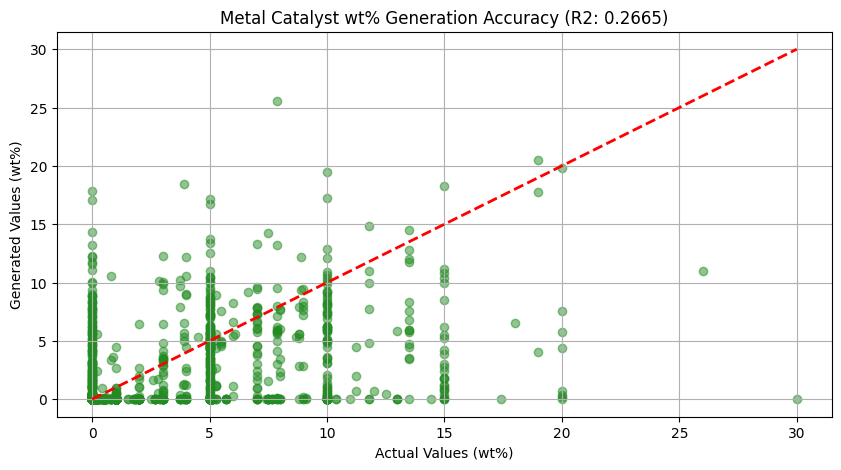

In [9]:
print("\n--- Final Pure Generation Test (Condition -> Metal Composition) ---")
m_bce.eval(); m_mse.eval()
all_gen, all_true = [], []

with torch.no_grad():
    for b1, b2, b3, bc in test_loader:
        bc = bc.to(device)
        # 정답 데이터 없이 오직 조건 bc로만 금속 촉매 함량 생성
        b_gen = m_bce.generate(bc, device)
        m_gen = m_mse.generate(bc, device)
        
        # Gating 적용: Sigmoid(BCE) * Raw(MSE)
        prob1 = torch.sigmoid(b_gen[0]) # Metal Existence Prob
        val1 = m_gen[0] # Metal Amount Raw
        
        final_metal = prob1 * val1
        # 미세 노이즈 제거를 위한 Thresholding
        final_metal[final_metal < 1e-3] = 0
        
        # 역스케일링 및 결과 수집
        all_gen.append(sc1.inverse_transform(final_metal.cpu().numpy()))
        all_true.append(sc1.inverse_transform(b1.numpy()))

y_p, y_t = np.concatenate(all_gen).flatten(), np.concatenate(all_true).flatten()
final_r2 = r2_score(y_t, y_p)
print(f"\n🏆 Final Metal Generation R2 Score: {final_r2:.4f}")

# 시각화
plt.figure(figsize=(10, 5))
plt.scatter(y_t, y_p, alpha=0.5, color='forestgreen')
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], 'r--', lw=2)
plt.title(f"Metal Catalyst wt% Generation Accuracy (R2: {final_r2:.4f})")
plt.xlabel("Actual Values (wt%)"); plt.ylabel("Generated Values (wt%)")
plt.grid(True); plt.show()